<h5>We will explore the WSJ (wall street journal) POS-tagged corpus that comes with NLTK and build POS Taggers using following approaches: </h5> <ul><li>Lexicon based Tagger</li><li>Rule-based Tagger</li><li>Hidden Markov Model Tagger</li><li>RNN Tagger</li><li>LSTM Tagger</li><li>GRU Tagger</li><li>Bi-Directional LSTM tagger</li> </u1>

### 1. Reading and understanding the tagged dataset

In [1]:
# Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import math
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle

In [2]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents())

In [3]:
# samples: Each sentence is a list of (word, pos) tuples
wsj[:3]

[[('Pierre', 'NNP'),
  ('Vinken', 'NNP'),
  (',', ','),
  ('61', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  (',', ','),
  ('will', 'MD'),
  ('join', 'VB'),
  ('the', 'DT'),
  ('board', 'NN'),
  ('as', 'IN'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('Nov.', 'NNP'),
  ('29', 'CD'),
  ('.', '.')],
 [('Mr.', 'NNP'),
  ('Vinken', 'NNP'),
  ('is', 'VBZ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Elsevier', 'NNP'),
  ('N.V.', 'NNP'),
  (',', ','),
  ('the', 'DT'),
  ('Dutch', 'NNP'),
  ('publishing', 'VBG'),
  ('group', 'NN'),
  ('.', '.')],
 [('Rudolph', 'NNP'),
  ('Agnew', 'NNP'),
  (',', ','),
  ('55', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  ('and', 'CC'),
  ('former', 'JJ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Consolidated', 'NNP'),
  ('Gold', 'NNP'),
  ('Fields', 'NNP'),
  ('PLC', 'NNP'),
  (',', ','),
  ('was', 'VBD'),
  ('named', 'VBN'),
  ('*-1', '-NONE-'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('of', 'IN'),
  ('this'

In the list mentioned above, each element of the list is a sentence. Also, note that each sentence ends with a full stop '.' whose POS tag is also a '.'. Thus, the POS tag '.' demarcates the end of a sentence.

Also, we do not need the corpus to be segmented into sentences, but can rather use a list of (word, tag) tuples. Let's convert the list into a (word, tag) tuple.

In [4]:
# converting the list of sents to a list of (word, pos tag) tuples
tagged_words = [tup for sent in wsj for tup in sent]
print(len(tagged_words))
tagged_words[:10]

100676


[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT')]

We now have a list of about 100676 (word, tag) tuples. Let's now do some exploratory analyses.

### 2. Exploratory Analysis

Let's now conduct some basic exploratory analysis to understand the tagged corpus. To start with, let's ask some simple questions:
1. How many unique tags are there in the corpus? 
2. Which is the most frequent tag in the corpus?
3. Which tag is most commonly assigned to the following words:
    - "bank"
    - "executive"


In [5]:
# Find the number of unique POS tags in the corpus

tags =  [tup[1] for tup in tagged_words]
unique_tags = set(tags)
len(unique_tags)

46

In [6]:
# Which is the most frequent tag in the corpus ?

from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NNP': 9410,
         ',': 4886,
         'CD': 3546,
         'NNS': 6047,
         'JJ': 5834,
         'MD': 927,
         'VB': 2554,
         'DT': 8165,
         'NN': 13166,
         'IN': 9857,
         '.': 3874,
         'VBZ': 2125,
         'VBG': 1460,
         'CC': 2265,
         'VBD': 3043,
         'VBN': 2134,
         '-NONE-': 6592,
         'RB': 2822,
         'TO': 2179,
         'PRP': 1716,
         'RBR': 136,
         'WDT': 445,
         'VBP': 1321,
         'RP': 216,
         'PRP$': 766,
         'JJS': 182,
         'POS': 824,
         '``': 712,
         'EX': 88,
         "''": 694,
         'WP': 241,
         ':': 563,
         'JJR': 381,
         'WRB': 178,
         '$': 724,
         'NNPS': 244,
         'WP$': 14,
         '-LRB-': 120,
         '-RRB-': 126,
         'PDT': 27,
         'RBS': 35,
         'FW': 4,
         'UH': 3,
         'SYM': 1,
         'LS': 13,
         '#': 16})

In [7]:
# the most common tags can be seen using the most_common() method of Counter
tag_counts.most_common(5)

[('NN', 13166), ('IN', 9857), ('NNP', 9410), ('DT', 8165), ('-NONE-', 6592)]

Thus, NN is the most common tag followed by IN, NNP, DT, -NONE- etc. You can read the exhaustive list of tags using the NLTK documentation as shown below.

In [8]:
# list of POS tags in NLTK
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [9]:
# Which tag is most commonly assigned to the word 'bank'? 
bank = Counter([tup[1] for tup in tagged_words if tup[0] == 'bank'])
bank

Counter({'NN': 38})

In [10]:
# Which tag is most commonly assigned to the word 'executive'?
executive = Counter([tup[1] for tup in tagged_words if tup[0] == 'executive'])
executive

Counter({'NN': 40, 'JJ': 28})

### 2. Exploratory Analysis Contd.

Until now, we were looking at the frequency of tags assigned to particular words, which is the basic idea used by lexicon or unigram taggers. Let's now try observing some rules which can potentially be used for POS tagging. 

To start with, let's see if the following questions reveal something useful:

4. What fraction of words with the tag 'VBD' (verb, past tense) end with the letters 'ed'
5. What fraction of words with the tag 'VBG' (verb, present participle/gerund) end with the letters 'ing'

In [11]:
# How many words with the tag 'VBD' (verb, past tense) end with 'ed'

# first get the all the words tagged as VBD
past_tense_verbs = [tup[0] for tup in tagged_words if tup[1] =='VBD']

# subset the past tense verbs with words ending with 'ed'.
ed_verbs = [word for word in past_tense_verbs if word[-2:] == 'ed']
print(len(ed_verbs) / len(past_tense_verbs))
ed_verbs[:20]

0.3881038448899113


['reported',
 'stopped',
 'studied',
 'led',
 'worked',
 'explained',
 'imposed',
 'dumped',
 'poured',
 'mixed',
 'described',
 'ventilated',
 'contracted',
 'continued',
 'eased',
 'ended',
 'lengthened',
 'reached',
 'resigned',
 'approved']

In [12]:
# How many words with the tag 'VBG' end with 'ing'?
participle_verbs = [tup[0] for tup in tagged_words if tup[1] =='VBG']
ing_verbs = [word for word in participle_verbs if word[-3:] == 'ing']
print(len(ing_verbs) / len(participle_verbs))
ing_verbs[:20]

0.9972602739726028


['publishing',
 'causing',
 'using',
 'talking',
 'having',
 'making',
 'surviving',
 'including',
 'including',
 'according',
 'remaining',
 'according',
 'declining',
 'rising',
 'yielding',
 'waiving',
 'holding',
 'holding',
 'cutting',
 'manufacturing']

## 2. Exploratory Analysis Continued

Let's now try observing some tag patterns using the fact the some tags are more likely to apper after certain other tags. For e.g. most nouns NN are usually followed by determiners DT ("The/DT constitution/NN"), adjectives JJ usually precede a noun NN (" A large/JJ building/NN"), etc. 

Try answering the following questions:
1. What fraction of adjectives JJ are followed by a noun NN? 
2. What fraction of determiners DT are followed by a noun NN?
3. What fraction of modals MD are followed by a verb VB?

In [13]:
# What fraction of adjectives JJ are followed by a noun NN?

# create a list of all tags (without the words)
tags = [tup[1] for tup in tagged_words]


# create a list of JJ tags
jj_tags = [tag for tag in tags if tag == 'JJ']

# create a list of (JJ, NN) tags
jj_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if tags[index] == 'JJ' and tags[index + 1] == 'NN']

print(len(jj_tags))
print(len(jj_nn_tags))
print(len(jj_nn_tags) / len(jj_tags))

5834
2611
0.4475488515598217


In [14]:
# What fraction of determiners DT are followed by a noun NN?
dt_tags = [tag for tag in tags if tag == 'DT']
dt_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if tags[index] == 'DT' and tags[index + 1] == 'NN']

print(len(dt_tags))
print(len(dt_nn_tags))
print(len(dt_nn_tags) / len(dt_tags))

8165
3844
0.470789957134109


In [15]:
# What fraction of modals MD are followed by a verb VB?
md_tags = [tag for tag in tags if tag == 'MD']
md_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if tags[index] == 'MD' and tags[index + 1] == 'VB']

print(len(md_tags))
print(len(md_vb_tags))
print(len(md_vb_tags) / len(md_tags))

927
756
0.8155339805825242


## 3. Lexicon, Rule-Based, HMM, Deep Learning Models for POS Tagging

Let's now see lexicon, rule-based, and HMM, Deep Learning models for POS tagging.
We'll first split the corpus into training and test sets and then use built-in NLTK taggers.

## 3.1 Splitting into Train and Test Sets

In [16]:
## 3.1 Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj, test_size=0.2)

print(len(train_set))
print(len(test_set))
print(train_set[:2])

3131
783
[[('A', 'DT'), ('shift', 'NN'), ('to', 'TO'), ('*', '-NONE-'), ('producing', 'VBG'), ('more', 'JJR'), ('alcohol', 'NN'), ('and', 'CC'), ('less', 'JJR'), ('sugar', 'NN'), ('had', 'VBD'), ('been', 'VBN'), ('expected', 'VBN'), ('*-1', '-NONE-'), (',', ','), ('but', 'CC'), ('the', 'DT'), ('latest', 'JJS'), ('news', 'NN'), (',', ','), ('if', 'IN'), ('true', 'JJ'), (',', ','), ('indicates', 'VBZ'), ('a', 'DT'), ('more', 'RBR'), ('drastic', 'JJ'), ('shift', 'NN'), ('0', '-NONE-'), ('than', 'IN'), ('*T*-2', '-NONE-'), ('had', 'VBD'), ('been', 'VBN'), ('anticipated', 'VBN'), ('*-3', '-NONE-'), ('.', '.')], [('Still', 'RB'), (',', ','), ('bankers', 'NNS'), ('expect', 'VBP'), ('packaging', 'NN'), ('to', 'TO'), ('flourish', 'VB'), (',', ','), ('primarily', 'RB'), ('because', 'IN'), ('more', 'JJR'), ('customers', 'NNS'), ('are', 'VBP'), ('demanding', 'VBG'), ('that', 'IN'), ('financial', 'JJ'), ('services', 'NNS'), ('be', 'VB'), ('tailored', 'VBN'), ('*-124', '-NONE-'), ('to', 'TO'), ('the

In [ ]:
accuracy = defaultdict()

## 3.2 Lexicon(Unigram) Tagger

Let's now try training a lexicon(or a unigram) tagger which assigns the most commonly assigned tag to a word.

In NLTK, the <b>UnigramTagger()</b> can be used to train such a model.

In [97]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.8835244119391183

Even a simple unigram tagger seems to perform fairly well.

In [18]:
# Bigram Tagger
bigram_tagger = nltk.BigramTagger(train_set)
bigram_tagger.evaluate(test_set)

0.1610990314291362

## 3.3 Rule-Based (Regular Expression) Tagger

Now let's build a rule-based, or regular expression based tagger. In NLTK, the <b>RegexpTagger</b> can be provided with handwritten regular expression patterns, as shown below.

In the example below, we specify regexes for gerunds and past tense verbs(as seen above), 3rd singular present verb(creates, moves, makes etc.), modal verbs MD(should, would, could), posessive nouns(partner's, bank's etc.), plural nouns(banks, institutions), cardinal numbers CD and finally, if none of the above are applicable to a word, we tag the most frequent tag NN.

In [19]:
# Specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),             # gerund
    (r'.*ed$', 'VBD'),              # past tense
    (r'.*es$', 'VBZ'),              # 3rd singular present
    (r'.*ould$', 'MD'),             # modals
    (r'.*\'s$', 'NN$'),             # posessive nouns
    (r'.*s$', 'NNS'),               # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),# cardinal numbers
    (r'.*', 'NN')                   # nouns
]

In [20]:
regex_tagger = nltk.RegexpTagger(patterns)

In [21]:
regex_tagger.evaluate(test_set)

0.21837319628385057

The reason for low accuracy can be ascribed to a handful of rules that we have defined.

## 3.4 Combining Bigram, Unigram, and Rule based Taggers

Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

NLTK provides a convenient way to combine taggers using 'backup' argument. In the following code, we create a regex tagger which is used as a backup tagger to the lexicon tagger, i.e when the tagger is not able to tag using the lexicon(in case of a new word in the vocabulary), it uses the rule-based tagger.

Also, note that the rule-based tagger itself is backed by the tag 'NN'.

In [22]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon/unigram backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

# bigram 
bigram_tagger = nltk.BigramTagger(train_set, backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)

0.9212294919944654

We try to tag the word using Bigram Tagger. If it does not find two words in the same sequence it backs off to unigram. If the unigram is also not found(happens when the word is not present in the training corpus), then it will simply back off to a rule based tagger. Finally, rule-based tagger has a backing offing system which is simply the NN tag.

## 3.5. Hidden Markov Model Taggers

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


In [23]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

80440

In [24]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['A',
 'shift',
 'to',
 '*',
 'producing',
 'more',
 'alcohol',
 'and',
 'less',
 'sugar']

In [25]:
# vocabulary
V = set(tokens)
print(len(V))

11079


In [26]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

46

In [27]:
print(T)

{'RP', ',', 'JJ', 'RB', 'CD', 'POS', '-NONE-', 'WP', 'VBD', '``', 'TO', 'WDT', 'EX', 'JJS', 'MD', 'NNS', 'VBG', 'PDT', "''", 'LS', 'CC', 'NN', 'PRP', 'DT', 'IN', 'NNP', 'SYM', 'WP$', 'NNPS', 'VBZ', 'VBN', '-LRB-', '#', 'PRP$', ':', '-RRB-', '.', 'VB', 'JJR', 'UH', 'RBS', 'WRB', 'VBP', '$', 'FW', 'RBR'}


### Emission Probabilities

In [28]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [29]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [30]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(22, 4699)
(0, 2044)
(0, 10552) 


 will
(225, 756)
(0, 10552)
(0, 2044)

 book
(4, 10552)
(1, 2044)


### Transition Probabilities

In [31]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [32]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(162, 4699)
(2090, 4699)
(3049, 6522)
(69, 2044)
(1109, 7422)
(3, 1352)
(6, 7422)


In [33]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))


(657, 3099)
(14, 3099)
(136, 3099)
(547, 3099)


In [34]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [35]:
tags_matrix

array([[0.0000000e+00, 2.9585799e-02, 5.3254437e-02, ..., 1.1834320e-02,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 4.1914620e-02, ..., 8.7968949e-03,
        2.5873221e-04, 7.7619666e-04],
       [2.1281124e-04, 2.6814215e-02, 6.5758675e-02, ..., 1.7024899e-03,
        0.0000000e+00, 4.2562248e-04],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.2522361e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.7857144e-02, 4.0178570e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [36]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [37]:
tags_df

,RP,",",JJ,RB,CD,POS,-NONE-,WP,VBD,``,...,.,VB,JJR,UH,RBS,WRB,VBP,$,FW,RBR
RP,0.000000,0.029586,0.053254,0.023669,0.011834,0.000000,0.118343,0.000000,0.000000,0.011834,...,0.029586,0.000000,0.011834,0.000000,0.000000,0.000000,0.000000,0.011834,0.000000,0.000000
",",0.000000,0.000000,0.041915,0.058732,0.025356,0.000000,0.033894,0.011125,0.052005,0.014230,...,0.000000,0.003105,0.001552,0.000000,0.000776,0.008538,0.008797,0.008797,0.000259,0.000776
JJ,0.000213,0.026814,0.065759,0.001915,0.021707,0.000000,0.020643,0.000213,0.000851,0.002128,...,0.021707,0.000000,0.000638,0.000000,0.000000,0.001064,0.000851,0.001702,0.000000,0.000426
RB,0.000000,0.090707,0.096043,0.070253,0.036016,0.000000,0.019120,0.001334,0.063584,0.001779,...,0.039573,0.103157,0.015562,0.000000,0.000000,0.001334,0.031125,0.008004,0.000000,0.007559
CD,0.000000,0.060159,0.031340,0.001801,0.184798,0.001081,0.210014,0.000360,0.005764,0.000000,...,0.047190,0.000000,0.001081,0.000000,0.000000,0.000360,0.003602,0.000000,0.000000,0.000720
POS,0.000000,0.007587,0.195751,0.003035,0.021244,0.000000,0.000000,0.000000,0.009105,0.007587,...,0.012140,0.000000,0.003035,0.000000,0.003035,0.000000,0.000000,0.007587,0.000000,0.000000
-NONE-,0.001334,0.051077,0.014675,0.023633,0.002859,0.000191,0.075281,0.000191,0.031065,0.002096,...,0.092624,0.009148,0.001906,0.000000,0.000191,0.000762,0.022489,0.002478,0.000000,0.001144
WP,0.000000,0.005405,0.000000,0.016216,0.005405,0.000000,0.800000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VBD,0.013676,0.010361,0.045586,0.077082,0.050145,0.000000,0.271032,0.000414,0.000000,0.004144,...,0.007460,0.001243,0.007460,0.000414,0.000000,0.001658,0.000000,0.013676,0.000000,0.002487
``,0.000000,0.000000,0.109185,0.077990,0.001733,0.000000,0.032929,0.008666,0.006932,0.000000,...,0.000000,0.012132,0.001733,0.000000,0.000000,0.010399,0.013865,0.000000,0.000000,0.000000


In [38]:
tags_df.loc['.', :]

RP        0.000000
,         0.000000
JJ        0.035495
RB        0.040981
CD        0.006454
POS       0.000000
-NONE-    0.023233
WP        0.002581
VBD       0.000645
``        0.072281
TO        0.001291
WDT       0.000323
EX        0.004518
JJS       0.001613
MD        0.000323
NNS       0.044853
VBG       0.004518
PDT       0.000645
''        0.060342
LS        0.001936
CC        0.049693
NN        0.043885
PRP       0.058083
DT        0.212004
IN        0.118103
NNP       0.176509
SYM       0.000000
WP$       0.000000
NNPS      0.001936
VBZ       0.002581
VBN       0.002259
-LRB-     0.003872
#         0.000000
PRP$      0.007744
:         0.003872
-RRB-     0.004840
.         0.000000
VB        0.000968
JJR       0.001936
UH        0.000323
RBS       0.000645
WRB       0.005808
VBP       0.000000
$         0.001613
FW        0.000000
RBR       0.000968
Name: ., dtype: float32

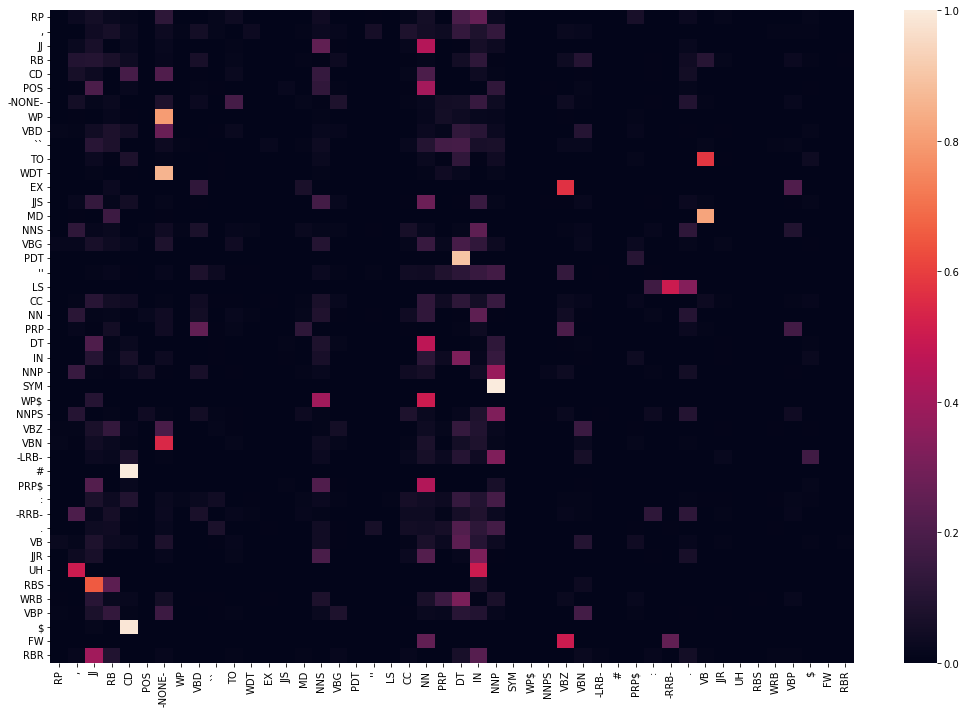

In [39]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


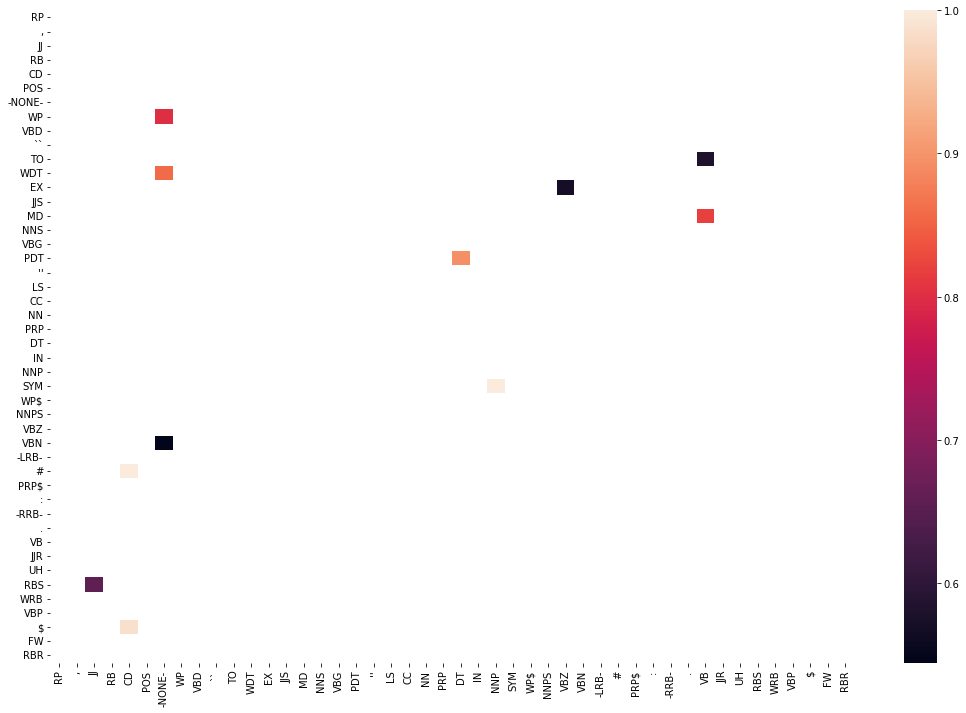

In [40]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [41]:
len(train_tagged_words)

80440

In [42]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [43]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('One', 'CD'),
  ('analyst', 'NN'),
  (',', ','),
  ('Arthur', 'NNP'),
  ('Stevenson', 'NNP'),
  (',', ','),
  ('of', 'IN'),
  ('Prudential-Bache', 'NNP'),
  ('Securities', 'NNPS'),
  (',', ','),
  ('New', 'NNP'),
  ('York', 'NNP'),
  (',', ','),
  ('estimated', 'VBD'),
  ('that', 'IN'),
  ('65', 'CD'),
  ('%', 'NN'),
  ('or', 'CC'),
  ('more', 'JJR'),
  ('of', 'IN'),
  ('Brazil', 'NNP'),
  ("'s", 'POS'),
  ('newly', 'RB'),
  ('made', 'VBN'),
  ('automobiles', 'NNS'),
  ('run', 'VBP'),
  ('on', 'IN'),
  ('alcohol', 'NN'),
  ('and', 'CC'),
  ('ca', 'MD'),
  ("n't", 'RB'),
  ('use', 'VB'),
  ('gasoline', 'NN'),
  ('.', '.')],
 [('The', 'DT'),
  ('Old', 'NNP'),
  ('Guard', 'NNP'),
  ("'s", 'POS'),
  ('assault', 'NN'),
  ('on', 'IN'),
  ('program', 'NN'),
  ('trading', 'NN'),
  ('and', 'CC'),
  ('its', 'PRP$'),
  ('practitioners', 'NNS'),
  ('has', 'VBZ'),
  ('been', 'VBN'),
  ('fierce', 'JJ'),
  ('and', 'CC'),
  ('broad-based', 'JJ'),
  (',', ','),
  ('in', 'IN'),
  ('part', 'NN'),
  ('

In [44]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [45]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  83.96265411376953
[('One', 'CD'), ('analyst', 'NN'), (',', ','), ('Arthur', 'NNP'), ('Stevenson', 'NNP'), (',', ','), ('of', 'IN'), ('Prudential-Bache', 'NNP'), ('Securities', 'NNPS'), (',', ','), ('New', 'NNP'), ('York', 'NNP'), (',', ','), ('estimated', 'VBD'), ('that', 'IN'), ('65', 'CD'), ('%', 'NN'), ('or', 'CC'), ('more', 'JJR'), ('of', 'IN'), ('Brazil', 'NNP'), ("'s", 'POS'), ('newly', 'RB'), ('made', 'VBN'), ('automobiles', 'NNS'), ('run', 'VBP'), ('on', 'IN'), ('alcohol', 'NN'), ('and', 'CC'), ('ca', 'MD'), ("n't", 'RB'), ('use', 'VB'), ('gasoline', 'NN'), ('.', '.'), ('The', 'DT'), ('Old', 'NNP'), ('Guard', 'NNP'), ("'s", 'POS'), ('assault', 'NN'), ('on', 'IN'), ('program', 'NN'), ('trading', 'NN'), ('and', 'CC'), ('its', 'PRP$'), ('practitioners', 'RP'), ('has', 'RP'), ('been', 'RP'), ('fierce', 'JJ'), ('and', 'CC'), ('broad-based', 'RP'), (',', ','), ('in', 'IN'), ('part', 'NN'), ('because', 'IN'), ('some', 'DT'), ('Old', 'NNP'), ('Guard', 'NNP'), ('

In [46]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [47]:
accuracy = len(check)/len(tagged_seq)

In [48]:
accuracy

0.8951612903225806

In [49]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [50]:
incorrect_tagged_cases

[[('its', 'PRP$'), (('practitioners', 'RP'), ('practitioners', 'NNS'))],
 [('practitioners', 'NNS'), (('has', 'RP'), ('has', 'VBZ'))],
 [('has', 'VBZ'), (('been', 'RP'), ('been', 'VBN'))],
 [('and', 'CC'), (('broad-based', 'RP'), ('broad-based', 'JJ'))],
 [('very', 'JJ'), (('livelihood', 'RP'), ('livelihood', 'NN'))],
 [('livelihood', 'NN'), (('is', 'RP'), ('is', 'VBZ'))],
 [('look', 'VBP'), (('around', 'IN'), ('around', 'RP'))],
 [('or', 'CC'), (('accountants', 'RP'), ('accountants', 'NNS'))],
 [('accountants', 'NNS'), (('...', 'RP'), ('...', ':'))],
 [('nobody', 'NN'), (('blinks', 'RP'), ('blinks', 'VBZ'))],
 [('``', '``'), (('Once', 'RB'), ('Once', 'IN'))],
 [('serious', 'JJ'), (('evaluation', 'RP'), ('evaluation', 'NN'))],
 [('managers', 'NNS'), (('pursue', 'VB'), ('pursue', 'VBP'))]]

In [51]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [52]:
print(tagged_seq)
print(difference)

[('Twitter', 'RP'), ('is', 'RP'), ('the', 'DT'), ('best', 'JJS'), ('networking', 'NN'), ('social', 'JJ'), ('site', 'RP'), ('.', '.'), ('Man', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), ('animal', 'RP'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('is', 'VBZ'), ('an', 'DT'), ('emerging', 'VBG'), ('field', 'NN'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('jobs', 'NNS'), ('are', 'VBP'), ('high', 'JJ'), ('in', 'IN'), ('demand', 'NN'), ('.', '.')]
18.43863606452942


## 3.6. Deep Learning Based Taggers

### Divide data in words (X) and tags (Y)

In [53]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in wsj:
    X_sentence = []
    Y_sentence = []
    for (word, tag) in sentence:         
        X_sentence.append(word)  
        Y_sentence.append(tag)  
        
    X.append(X_sentence)
    Y.append(Y_sentence)

### Vectorise X and Y

In [54]:
# encode X
word_tokenizer = Tokenizer()              # instantiate tokeniser
word_tokenizer.fit_on_texts(X)            # fit tokeniser on data
# use the tokeniser to encode input sequence
X_encoded = word_tokenizer.texts_to_sequences(X)  

# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

# look at first encoded data point
print("** Raw data point **", "\n", "-"*115, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*115, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ------------------------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 


** Encoded data point ** 
 ------------------------------------------------------------------------------------------------------------------- 

X:  [5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3] 

Y:  [3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9] 



### Pad sequences

In [55]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS’ pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.
# Truncation and padding can either be ‘pre’ or ‘post’. 
# For padding we are using ‘pre’ padding type, that is, add zeroes on the left side.
# For truncation, we are using ‘post’, that is, truncate a sentence from right side.
# sequences greater than 100 in length will be truncated
MAX_SEQ_LENGTH = 100
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 5601 3746
    1 2024   86  331    1   46 2405    2  131   27    6 2025  332  459
 2026    3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  3  8 10  6  7  8 21 13  4  1  2  4  7
  1  3 10  9]


In [56]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

### Word embeddings

In [57]:
# word2vec
path = 'GoogleNews-vectors-negative300.bin'
# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)
# assign word vectors from word2vec model
# each word in word2vec model is represented using a 300 dimensional vector
EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

### Use one-hot encoding for output sequences (Y)

In [58]:
# use Keras’ to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [59]:
# print Y of the first output sequqnce
print(Y.shape)

(3914, 100, 47)


### Split data in training, validation and tesing sets

In [60]:
# split entire data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

# split training data into training and validation sets
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=4)

In [61]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (2504, 100)
Shape of output sequences: (2504, 100, 47)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (627, 100)
Shape of output sequences: (627, 100, 47)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (783, 100)
Shape of output sequences: (783, 100, 47)


### Vanilla RNN

In [62]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [63]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

2023-05-29 21:04:32.999985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [64]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [65]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          3416400   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 47)          3055      
 ibuted)                                                         
                                                                 
Total params: 3,442,815
Trainable params: 26,415
Non-trainable params: 3,416,400
_________________________________________________________________


In [66]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
20/20 [==============================] - 5s 145ms/step - loss: 2.4617 - acc: 0.6617 - val_loss: 1.4421 - val_acc: 0.7475
Epoch 2/10
20/20 [==============================] - 2s 103ms/step - loss: 1.2181 - acc: 0.7437 - val_loss: 1.0255 - val_acc: 0.7560
Epoch 3/10
20/20 [==============================] - 2s 115ms/step - loss: 0.9887 - acc: 0.7647 - val_loss: 0.9213 - val_acc: 0.7762
Epoch 4/10
20/20 [==============================] - 2s 113ms/step - loss: 0.9145 - acc: 0.7715 - val_loss: 0.8728 - val_acc: 0.7773
Epoch 5/10
20/20 [==============================] - 2s 102ms/step - loss: 0.8774 - acc: 0.7726 - val_loss: 0.8457 - val_acc: 0.7774
Epoch 6/10
20/20 [==============================] - 2s 99ms/step - loss: 0.8539 - acc: 0.7730 - val_loss: 0.8257 - val_acc: 0.7785
Epoch 7/10
20/20 [==============================] - 2s 106ms/step - loss: 0.8354 - acc: 0.7738 - val_loss: 0.8081 - val_acc: 0.7787
Epoch 8/10
20/20 [==============================] - 2s 105ms/step - loss: 0.8

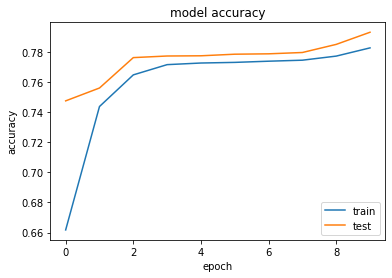

In [67]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Uninitialised trainable embeddings

In [68]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [69]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [70]:
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 3,442,815
Trainable params: 3,442,815
Non-trainable params: 0
_________________________________________________________________


In [71]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
20/20 [==============================] - 6s 206ms/step - loss: 2.2299 - acc: 0.6646 - val_loss: 1.2596 - val_acc: 0.7475
Epoch 2/10
20/20 [==============================] - 3s 166ms/step - loss: 1.0928 - acc: 0.7510 - val_loss: 0.9364 - val_acc: 0.7778
Epoch 3/10
20/20 [==============================] - 4s 208ms/step - loss: 0.8756 - acc: 0.7937 - val_loss: 0.7952 - val_acc: 0.8264
Epoch 4/10
20/20 [==============================] - 4s 219ms/step - loss: 0.7478 - acc: 0.8463 - val_loss: 0.6872 - val_acc: 0.8589
Epoch 5/10
20/20 [==============================] - 4s 189ms/step - loss: 0.6364 - acc: 0.8723 - val_loss: 0.5824 - val_acc: 0.8780
Epoch 6/10
20/20 [==============================] - 4s 202ms/step - loss: 0.5264 - acc: 0.8933 - val_loss: 0.4828 - val_acc: 0.8957
Epoch 7/10
20/20 [==============================] - 4s 201ms/step - loss: 0.4273 - acc: 0.9168 - val_loss: 0.3982 - val_acc: 0.9185
Epoch 8/10
20/20 [==============================] - 3s 166ms/step - loss: 0.

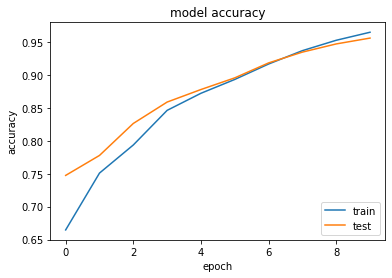

In [72]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Using pre-trained embedding weights

In [73]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [74]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [75]:
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 3,442,815
Trainable params: 3,442,815
Non-trainable params: 0
_________________________________________________________________


In [76]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
20/20 [==============================] - 6s 236ms/step - loss: 2.4778 - acc: 0.7356 - val_loss: 1.2670 - val_acc: 0.7547
Epoch 2/10
20/20 [==============================] - 4s 192ms/step - loss: 1.0860 - acc: 0.7748 - val_loss: 0.9075 - val_acc: 0.8223
Epoch 3/10
20/20 [==============================] - 4s 200ms/step - loss: 0.8185 - acc: 0.8438 - val_loss: 0.7103 - val_acc: 0.8639
Epoch 4/10
20/20 [==============================] - 5s 235ms/step - loss: 0.6323 - acc: 0.8804 - val_loss: 0.5417 - val_acc: 0.8939
Epoch 5/10
20/20 [==============================] - 4s 218ms/step - loss: 0.4706 - acc: 0.9113 - val_loss: 0.4056 - val_acc: 0.9241
Epoch 6/10
20/20 [==============================] - 5s 229ms/step - loss: 0.3467 - acc: 0.9396 - val_loss: 0.3097 - val_acc: 0.9452
Epoch 7/10
20/20 [==============================] - 4s 199ms/step - loss: 0.2599 - acc: 0.9585 - val_loss: 0.2434 - val_acc: 0.9576
Epoch 8/10
20/20 [==============================] - 3s 163ms/step - loss: 0.

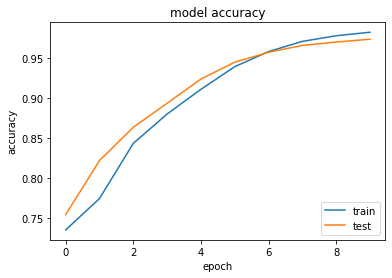

In [77]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [78]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

25/25 [==============================] - 1s 19ms/step - loss: 0.1446 - acc: 0.9735
Loss: 0.14459678530693054,
Accuracy: 0.9735121130943298


### LSTM

In [79]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [80]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [81]:
# check summary of the model
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 3,512,895
Trainable params: 3,512,895
Non-trainable params: 0
_________________________________________________________________


In [82]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_validation, Y_validation))

Epoch 1/20
20/20 [==============================] - 8s 287ms/step - loss: 2.9844 - acc: 0.7540 - val_loss: 1.5468 - val_acc: 0.7475
Epoch 2/20
20/20 [==============================] - 5s 256ms/step - loss: 1.2843 - acc: 0.7459 - val_loss: 1.0468 - val_acc: 0.7602
Epoch 3/20
20/20 [==============================] - 5s 255ms/step - loss: 0.9904 - acc: 0.7626 - val_loss: 0.8987 - val_acc: 0.7742
Epoch 4/20
20/20 [==============================] - 5s 254ms/step - loss: 0.8759 - acc: 0.7771 - val_loss: 0.8217 - val_acc: 0.7856
Epoch 5/20
20/20 [==============================] - 5s 255ms/step - loss: 0.8095 - acc: 0.7880 - val_loss: 0.7674 - val_acc: 0.7984
Epoch 6/20
20/20 [==============================] - 5s 256ms/step - loss: 0.7566 - acc: 0.8077 - val_loss: 0.7154 - val_acc: 0.8303
Epoch 7/20
20/20 [==============================] - 5s 253ms/step - loss: 0.6984 - acc: 0.8417 - val_loss: 0.6524 - val_acc: 0.8555
Epoch 8/20
20/20 [==============================] - 5s 262ms/step - loss: 0.

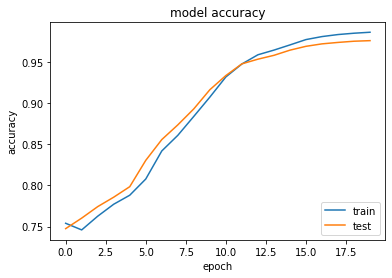

In [83]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [84]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

25/25 [==============================] - 1s 29ms/step - loss: 0.1204 - acc: 0.9755
Loss: 0.1204322949051857,
Accuracy: 0.9754661321640015


### GRU

In [85]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [86]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [87]:
# check summary of model
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 3,489,727
Trainable params: 3,489,727
Non-trainable params: 0
_________________________________________________________________


In [88]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
20/20 [==============================] - 7s 265ms/step - loss: 3.2296 - acc: 0.7852 - val_loss: 1.5276 - val_acc: 0.7895
Epoch 2/10
20/20 [==============================] - 5s 253ms/step - loss: 1.0579 - acc: 0.7898 - val_loss: 0.8823 - val_acc: 0.8153
Epoch 3/10
20/20 [==============================] - 6s 287ms/step - loss: 0.8144 - acc: 0.8147 - val_loss: 0.7245 - val_acc: 0.8099
Epoch 4/10
20/20 [==============================] - 5s 262ms/step - loss: 0.6816 - acc: 0.8295 - val_loss: 0.6099 - val_acc: 0.8661
Epoch 5/10
20/20 [==============================] - 5s 231ms/step - loss: 0.5524 - acc: 0.8922 - val_loss: 0.4781 - val_acc: 0.9097
Epoch 6/10
20/20 [==============================] - 5s 231ms/step - loss: 0.4141 - acc: 0.9249 - val_loss: 0.3548 - val_acc: 0.9345
Epoch 7/10
20/20 [==============================] - 6s 307ms/step - loss: 0.2993 - acc: 0.9487 - val_loss: 0.2661 - val_acc: 0.9531
Epoch 8/10
20/20 [==============================] - 5s 266ms/step - loss: 0.

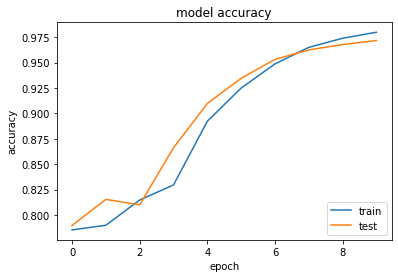

In [89]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [90]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

25/25 [==============================] - 1s 21ms/step - loss: 0.1453 - acc: 0.9709
Loss: 0.1453438252210617,
Accuracy: 0.970855712890625


### Bidirectional LSTM

In [91]:
# create architecture
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
 input_length = MAX_SEQ_LENGTH,
 weights = [embedding_weights],
 trainable = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
# check summary of model
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 47)          6063      
 tributed)                                                       
                                                                 
Total params: 3,609,343
Trainable params: 3,609,343
Non-trainable params: 0
_________________________________________________________________


In [92]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
20/20 [==============================] - 15s 565ms/step - loss: 2.7681 - acc: 0.7203 - val_loss: 1.1495 - val_acc: 0.7475
Epoch 2/10
20/20 [==============================] - 12s 587ms/step - loss: 0.9194 - acc: 0.7688 - val_loss: 0.8066 - val_acc: 0.7819
Epoch 3/10
20/20 [==============================] - 8s 412ms/step - loss: 0.7909 - acc: 0.7824 - val_loss: 0.7451 - val_acc: 0.8083
Epoch 4/10
20/20 [==============================] - 8s 400ms/step - loss: 0.7400 - acc: 0.8111 - val_loss: 0.7004 - val_acc: 0.8232
Epoch 5/10
20/20 [==============================] - 8s 398ms/step - loss: 0.6913 - acc: 0.8309 - val_loss: 0.6465 - val_acc: 0.8459
Epoch 6/10
20/20 [==============================] - 8s 402ms/step - loss: 0.6263 - acc: 0.8523 - val_loss: 0.5731 - val_acc: 0.8673
Epoch 7/10
20/20 [==============================] - 8s 400ms/step - loss: 0.5384 - acc: 0.8773 - val_loss: 0.4798 - val_acc: 0.8918
Epoch 8/10
20/20 [==============================] - 8s 422ms/step - loss: 

In [93]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

25/25 [==============================] - 1s 48ms/step - loss: 0.2411 - acc: 0.9555
Loss: 0.24108107388019562,
Accuracy: 0.9554661512374878
